In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import numpy as np
import math
import time
# to import covariance module later
import sys
sys.path.append('../skrmt')

## Sampling random population covariance matrix (Sigma)

#### First, let's build a method to sample orthogonal random matrices

In [3]:
def sample_rand_orthogonal_mtx(n):
    # n by n random complex matrix
    X = np.random.randn(n,n)
    # orthonormalizing matrix using QR algorithm
    Q,_ = np.linalg.qr(X)
    return Q

In [4]:
M = sample_rand_orthogonal_mtx(5) 
# the printed matrix should be the identity
np.round(np.matmul(M, M.T), 12)

array([[ 1., -0.,  0.,  0., -0.],
       [-0.,  1., -0.,  0., -0.],
       [ 0., -0.,  1., -0.,  0.],
       [ 0.,  0., -0.,  1., -0.],
       [-0., -0.,  0., -0.,  1.]])

#### Now, let's sample a diagonal matrix with a certain proportion of eigenvalues:
    - eigenvalues equal to 1: 20%
    - eigenvalues equal to 3: 40%
    - eigenvalues equal to 10: 40%

In [5]:
def sample_diagEig_mtx(p):
    ONE_PROP = 0.2    # proportion of eigenvalues equal to one
    THREE_PROP = 0.4  # proportion of eigenvalues equal to three
    TEN_PROP = 0.4    # proportion of eigenvalues equal to ten

    n_one = math.ceil(p * ONE_PROP)       # number of eigenvalues equal to one
    n_three = math.floor(p * THREE_PROP)  # number of eigenvalues equal to three
    n_ten = p - n_one - n_three           # number of eigenvalues equal to ten

    # building eigenvalues
    one_eigs = [1.0]*n_one
    three_eigs = [3.0]*n_three
    ten_eigs = [10.0]*n_ten
    # concatenating eigenvalues lists
    eigs = one_eigs + three_eigs + ten_eigs
    # shuffling eigenvalues
    np.random.shuffle(eigs)
    # building diagonal matrix
    M = np.diag(eigs)
    return M

In [6]:
# the printed matrix should have one '1', two '3' and two '10' in its diagonal
sample_diagEig_mtx(5)

array([[10.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  3.]])

#### to create a random population matrix, that is not necessarily diagonal, we use both functions

In [7]:
def sample_pop_cov(p, diag=False):
    if diag:
        return sample_diagEig_mtx(p)
    else:
        O = sample_rand_orthogonal_mtx(p)
        M = sample_diagEig_mtx(p)
        # O M O.T preserves original eigenvalues (O is an orthogonal rotation)
        return np.matmul(np.matmul(O, M), O.T) # sampling \Sigma

In [8]:
Sigma = sample_pop_cov(5)
# printing Sigma, population covariance matrix
print('Sigma:\n', Sigma)
# printing Sigma eigenvalues, that should be equal to the specified eigenvalues above.
print('Sigma eigenvalues:', np.linalg.eigvals(Sigma))

Sigma:
 [[ 6.74285649  0.06290439  2.88855441 -2.48667261  1.15603757]
 [ 0.06290439  2.71329165  1.0546551  -0.04783621  0.57437687]
 [ 2.88855441  1.0546551   7.14193287  2.34780631 -0.16536299]
 [-2.48667261 -0.04783621  2.34780631  7.97157279 -0.06622793]
 [ 1.15603757  0.57437687 -0.16536299 -0.06622793  2.43034619]]
Sigma eigenvalues: [ 1. 10. 10.  3.  3.]


## Sampling dataset using population covariance matrix Sigma

#### To do so we specify the number of attributes (p) and the number of observations to sample (n). After sampling a population covariance matrix Sigma, we can use it to create a n random samples of the population, generating the dataset X.

In [9]:
p, n = 5, 10

Sigma = sample_pop_cov(p)
X = np.random.multivariate_normal(np.random.randn(p), Sigma, size=n)
print('Shape:', X.shape)
print('Random generated dataset:\n', X)

Shape: (10, 5)
Random generated dataset:
 [[ 2.60785546  1.6860382  -1.24241121 -0.82553858 -2.72487719]
 [ 5.68240881  0.01011305  2.84529382 -1.20992114 -3.71301147]
 [ 7.19425167 -1.64033031  5.02298692  4.84191197  1.64743103]
 [ 1.83811212  1.86723869  0.78742727  2.91300675  0.92718321]
 [ 5.34741752 -0.3869743   4.48881422 -1.82853763  3.21087016]
 [ 6.00550893  0.14015961  1.64108017 -2.02774755  3.25265501]
 [ 4.47002018  0.44165237  2.43752587 -2.37942344 -1.40076702]
 [ 2.13945705 -1.82753385  1.41896795  4.64480887  0.34538655]
 [ 3.83089861  1.3468016   0.23686567  0.80092132 -0.16173728]
 [ 1.96264209  1.47541928 -0.6653664   0.36222669 -3.74460653]]


##  Small tests of estimators and metrics

In [10]:
p, n = 200, 600

Sigma = sample_pop_cov(p)
X = np.random.multivariate_normal(np.random.randn(p), Sigma, size=n)
print('Shape:', X.shape)

Shape: (600, 200)


In [11]:
from covariance import sample_estimator

In [12]:
Sigma_sample = sample_estimator(X)
# the printed shape should be equal to (p,p)
print('S sample estimator shape:', Sigma_sample.shape)

S sample estimator shape: (200, 200)


In [14]:
from covariance import fsopt_estimator

In [15]:
Sigma_fsopt = fsopt_estimator(X, Sigma)
# the printed shape should be equal to (p,p)
print('S sample estimator shape:', Sigma_fsopt.shape)

S sample estimator shape: (200, 200)


### Checking that PRIAL(S) = 0%

In [16]:
from covariance import loss_mv, prial_mv

In [18]:
exp_sample = loss_mv(sigma_tilde=Sigma_sample, sigma=Sigma)
exp_sigma_tilde = loss_mv(sigma_tilde=Sigma_sample, sigma=Sigma)
exp_fsopt = loss_mv(sigma_tilde=Sigma_fsopt, sigma=Sigma)

prial_mv(exp_sample=exp_sample, exp_sigma_tilde=exp_sigma_tilde, exp_fsopt=exp_fsopt)

0.0

### Checking that PRIAL(S_star) = 100%

In [19]:
exp_sample = loss_mv(sigma_tilde=Sigma_sample, sigma=Sigma)
exp_sigma_tilde = loss_mv(sigma_tilde=Sigma_fsopt, sigma=Sigma)
exp_fsopt = loss_mv(sigma_tilde=Sigma_fsopt, sigma=Sigma)

prial_mv(exp_sample=exp_sample, exp_sigma_tilde=exp_sigma_tilde, exp_fsopt=exp_fsopt)

1.0

#### After these tests we are more confident that estimators FSOptEstimator and SampleEstimator, as well as metrics loss_mv and PRIAL_mv, are working properly

# Monte Carlo simulations for covariance module

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
# importing all estimators
from covariance import sample_estimator
from covariance import fsopt_estimator
from covariance import linear_shrinkage_estimator
from covariance import analytical_shrinkage_estimator
from covariance import empirical_bayesian_estimator
from covariance import minimax_estimator
# importing metrics
from covariance import loss_mv, prial_mv

In [22]:
def sample_dataset(p, n, Sigma=None):
    if Sigma is None:
        Sigma = sample_pop_cov(p)
    X = np.random.multivariate_normal(np.random.randn(p), Sigma, size=n)
    return X, Sigma

In [31]:
def run_simulation(p, n, estimators, nreps=100):
    # adviced to check prial_mv formula to understand the code below
    Sn_idx = 0
    Sstar_idx = 1
    Sigma_tilde_idx = 2
    # generating population covariance matrix
    Sigma = sample_pop_cov(p)

    # matrices/arrays of results
    # +2 because sample and FSOptimal estimators are always considered
    LOSSES = np.zeros((len(estimators)+2, 3))
    PRIALS = np.zeros(len(estimators)+2)
    TIMES = np.zeros((len(estimators)+2))

    for (idx, estimator) in enumerate(estimators):
        t1 = time.time()
        for i in range(nreps):
            # sampling random dataset from fixed population covariance matrix
            X, _ = sample_dataset(p=p, n=n, Sigma=Sigma)
            # estimating sample cov
            Sample = sample_estimator(X)
            # estimating S_star
            S_star = fsopt_estimator(X, Sigma)
            # estimating population covariance matrix using current estimator
            Sigma_tilde = estimator(X)
            # calculating losses
            loss_Sn = loss_mv(sigma_tilde=Sample, sigma=Sigma)
            loss_Sstar = loss_mv(sigma_tilde=S_star, sigma=Sigma)
            loss_Sigma_tilde = loss_mv(sigma_tilde=Sigma_tilde, sigma=Sigma)
            LOSSES[idx][Sn_idx] += loss_Sn
            LOSSES[idx][Sstar_idx] += loss_Sstar
            LOSSES[idx][Sigma_tilde_idx] += loss_Sigma_tilde
        t2 = time.time()
        TIMES[idx] = (t2-t1)*1000/nreps # time needed in ms (meaned by number of repetitions)
        LOSSES[idx] /= p
        PRIALS[idx] = prial_mv(exp_sample=LOSSES[idx][Sn_idx],
                               exp_sigma_tilde=LOSSES[idx][Sigma_tilde_idx],
                               exp_fsopt=LOSSES[idx][Sstar_idx])
        
    # Sample estimator
    t1 = time.time()
    for i in range(nreps):
        # sampling random dataset from fixed population covariance matrix
        X, _ = sample_dataset(p=p, n=n, Sigma=Sigma)
        # estimating sample cov
        Sample = sample_estimator(X)
        # estimating S_star
        S_star = fsopt_estimator(X, Sigma)
        # estimating population covariance matrix using sample estimator
        Sigma_tilde = sample_estimator(X)
        # calculating losses
        loss_Sn = loss_mv(sigma_tilde=Sample, sigma=Sigma)
        loss_Sstar = loss_mv(sigma_tilde=S_star, sigma=Sigma)
        loss_Sigma_tilde = loss_mv(sigma_tilde=Sigma_tilde, sigma=Sigma)
        LOSSES[-2][Sn_idx] += loss_Sn
        LOSSES[-2][Sstar_idx] += loss_Sstar
        LOSSES[-2][Sigma_tilde_idx] += loss_Sigma_tilde
    t2 = time.time()
    TIMES[-2] = (t2-t1)*1000/nreps # time needed in ms (meaned by number of repetitions)
    LOSSES[-2] /= p
    PRIALS[-2] = prial_mv(exp_sample=LOSSES[-2][Sn_idx],
                          exp_sigma_tilde=LOSSES[-2][Sigma_tilde_idx],
                          exp_fsopt=LOSSES[-2][Sstar_idx])
    
    # FSOpt estimator
    t1 = time.time()
    for i in range(nreps):
        # sampling random dataset from fixed population covariance matrix
        X, _ = sample_dataset(p=p, n=n, Sigma=Sigma)
        # estimating sample cov
        Sample = sample_estimator(X)
        # estimating S_star
        S_star = fsopt_estimator(X, Sigma)
        # estimating population covariance matrix using current estimator
        Sigma_tilde = fsopt_estimator(X, Sigma)
        # calculating losses
        loss_Sn = loss_mv(sigma_tilde=Sample, sigma=Sigma)
        loss_Sstar = loss_mv(sigma_tilde=S_star, sigma=Sigma)
        loss_Sigma_tilde = loss_mv(sigma_tilde=Sigma_tilde, sigma=Sigma)
        LOSSES[-1][Sn_idx] += loss_Sn
        LOSSES[-1][Sstar_idx] += loss_Sstar
        LOSSES[-1][Sigma_tilde_idx] += loss_Sigma_tilde
    t2 = time.time()
    TIMES[-1] = (t2-t1)*1000/nreps # time needed in ms (meaned by number of repetitions)
    LOSSES[-1] /= p
    PRIALS[-1] = prial_mv(exp_sample=LOSSES[-1][Sn_idx],
                          exp_sigma_tilde=LOSSES[-1][Sigma_tilde_idx],
                          exp_fsopt=LOSSES[-1][Sstar_idx])
        
    return LOSSES, PRIALS, TIMES


In [32]:
def run_graphic_simulation(estimators, labels, P_list=[5, 50, 100, 150, 200, 300, 400, 500],
                           N=None, ratio=3, nreps=None, metric='prial'):

    # +2 because sample and FSOptimal estimators are always considered
    MEASURES = np.zeros((len(P_list), len(estimators)+2))
    labels += ['Sample', 'FSOpt']

    ratios = []

    for (idx, p) in enumerate(P_list):
        if N is None:
            n = ratio*p
        else:
            n = N
            ratios.append(p/n)
        if nreps is None:
            nreps = int(max(100, min(1000, 10000/p)))

        losses, prials, times = run_simulation(p, n, estimators, nreps=nreps)
        if metric == 'prial':
            MEASURES[idx] = prials
        elif metric == 'loss':
            MEASURES[idx] = losses
        elif metric == 'time':
            MEASURES[idx] = times

    if N is None:
        lines = plt.plot(P_list, MEASURES, '-D')
        plt.xlabel('Matrix dimension p')
    else:
        lines = plt.plot(ratios, MEASURES, '-D')
        plt.xlabel('Ratio p/n')
    plt.legend(lines, labels)

    if metric == 'prial':
        plt.title('Evolution of PRIAL (reps='+str(nreps)+')')
        plt.ylabel('PRIAL')
    elif metric == 'loss':
        plt.title('Evolution of Loss (reps='+str(nreps)+')')
        plt.ylabel('Loss')
    elif metric == 'time':
        plt.title('Duration study on average (reps='+str(nreps)+')')
        plt.ylabel('time (ms)')


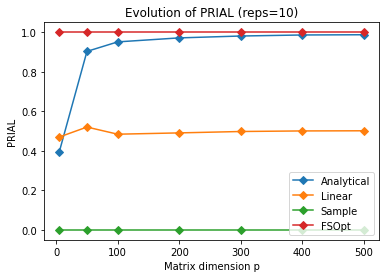

In [40]:
estimators = [analytical_shrinkage_estimator, linear_shrinkage_estimator]

labels = ['Analytical', 'Linear']
P_list = [5, 50, 100, 200, 300, 400, 500]

run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='prial')

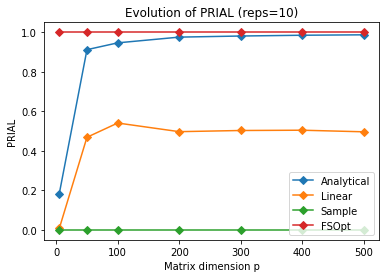

In [48]:
run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='prial')

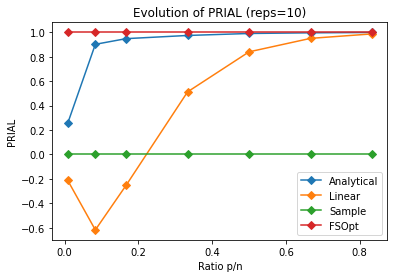

In [53]:
run_graphic_simulation(estimators, labels, P_list=P_list, N=600, nreps=10, metric='prial')

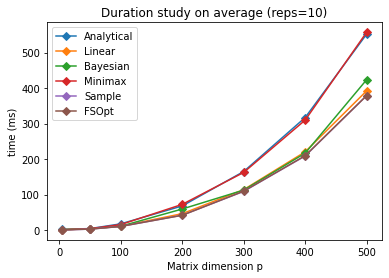

In [76]:
run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='time')

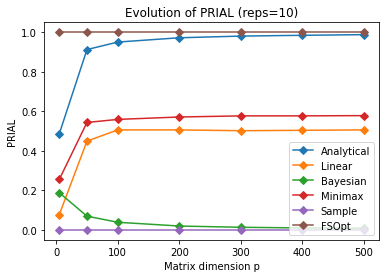

In [66]:
# Using now all estimators
estimators = [analytical_shrinkage_estimator, linear_shrinkage_estimator,
              empirical_bayesian_estimator, minimax_estimator]

labels = ['Analytical', 'Linear', 'Bayesian', 'Minimax']
P_list = [5, 50, 100, 200, 300, 400, 500]

run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='prial')

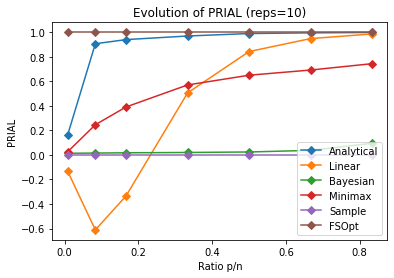

In [67]:
run_graphic_simulation(estimators, labels, P_list=P_list, N=600, nreps=10, metric='prial')

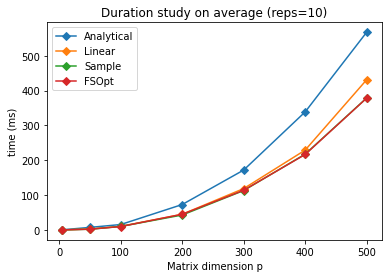

In [71]:
run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='time')

### Let's execute simulations with a greater amount of repetitions

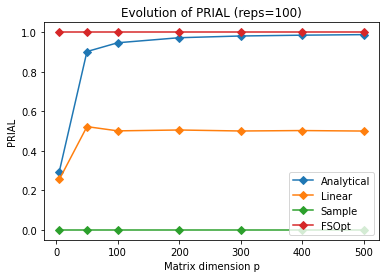

In [68]:
estimators = [analytical_shrinkage_estimator, linear_shrinkage_estimator]

labels = ['Analytical', 'Linear']
P_list = [5, 50, 100, 200, 300, 400, 500]

run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=100, metric='prial')

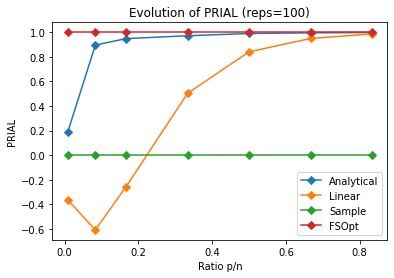

In [69]:
run_graphic_simulation(estimators, labels, P_list=P_list, N=600, nreps=100, metric='prial')

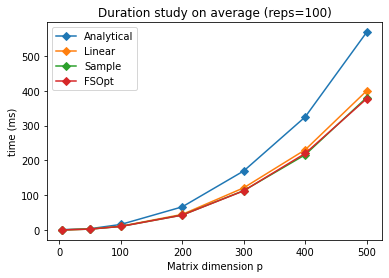

In [72]:
run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=100, metric='time')

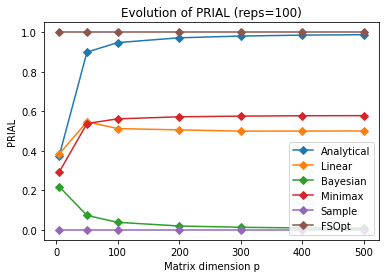

In [73]:
# Using now all estimators
estimators = [analytical_shrinkage_estimator, linear_shrinkage_estimator,
              empirical_bayesian_estimator, minimax_estimator]

labels = ['Analytical', 'Linear', 'Bayesian', 'Minimax']
P_list = [5, 50, 100, 200, 300, 400, 500]

run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=100, metric='prial')

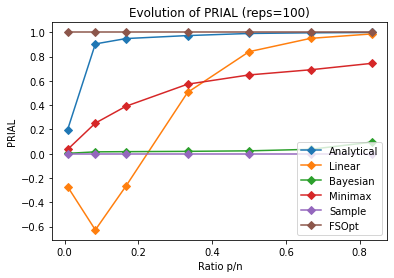

In [74]:
run_graphic_simulation(estimators, labels, P_list=P_list, N=600, nreps=100, metric='prial')

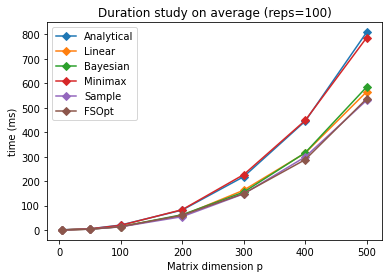

In [75]:
run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=100, metric='time')